# 2 label classification in classical ML and QML

## classical classification

#### Definition

\begin{align*}
    {\bf X} &= [{\bf x}_1 {\bf x}_2 \cdots {\bf x}_N ]^T \quad {\bf x}_1 = [x_{11},\,.. ,\,x_{1N}]^T \quad (|{\bf x}_i| = 2, \quad N = 4 \quad\text{for OR dataset})\\
    {\bf W} &= [{\bf w}_1 {\bf w}_2 \cdots {\bf w}_m] \quad{\bf w}_i;\text{weight vector for output i}  \quad w_{ji}; \text{weight of input j for output i} \quad(|{\bf w}_i| = 2, \quad m = 2 \quad\text{for OR dataset})\\
    \hat{y}_{ij} &= \text{softmax}({\bf x}_i^T {\bf w}_j + b), 
    \quad {\bf y}_1 = [y_{11},\,.. ,\,y_{1N}]^T
\end{align*}

#### Model
$$
    {\bf Y} = [{\hat{\bf y}}_1 {\hat{\bf y}}_2 \cdots {\hat{\bf y}}_N]^{\mathrm{T}}
    = \mathrm{softmax}({\bf X}{\bf W} + {\bf B}) \quad |Y| = N*|{\bf w}_i| \quad {\bf B} = [{\bf b}\, {\bf b}\, \cdots {\bf b}]^{\mathrm{T}}\quad |{\bf B}| = N * |{\bf w}_i|
$$

#### Multiclass cross entropy loss function

$$
E ({\bf x}, {\bf y}; {\bf W}, {\bf b} ) =  -\frac{1}{N}\sum^N_{i=1} \sum^K_{k=1} y_{i, k} \log \hat{y}_{i, k} ({\bf x}^{\mathrm{T}}_i {\bf w}_k+b_k) 
$$

#### Learning

\begin{align*}
    {\bf \delta}_i &= {\bf \hat{y}}_i - {\bf y}_i\\
    {\bf \Delta} &= [\delta_1\delta_2 \cdots \delta_N]\\
    \nabla_{\bf W} E &= \frac{1}{N} {\bf X} {\bf \Delta}^{\mathrm{T}}\\
    \nabla_{\bf b} E &= \frac{1}{N} {\bf\Delta}^{\mathrm{T}}  \\
    {\bf W} &\leftarrow {\bf W} - \epsilon \nabla_{\bf W} E \\
    {\bf B} &\leftarrow {\bf B} - \epsilon \nabla_{\bf b} E \\
\end{align*}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

np.random.seed(34)

In [10]:
def softmax(x):
    x -= x.max(axis=1, keepdims=True) # avoid exp overflow
    x_exp = np.exp(x)
    return x_exp / np.sum(x_exp, axis=1, keepdims=True)

# avoid log(0)
def np_log(x):
    return np.log(np.clip(a=x, a_min=1e-10, a_max=1e+10))

def train_or(x, y, W, b, eps=10):
    """
    :param x: np.ndarray, inputs, shape=(batch_size, dim_input)
    :param y: np.ndarray, outputs, shape=(batch_size, dim_output)
    :param eps: float, learning rate
    """

    batch_size = x.shape[0] # 4

    y_hat = softmax(np.matmul(x, W) + b) # shape: x:(4,2) W:(2,2) b:2 y_hat:(4,2)

    delta = y_hat - y # shape: delta:(4,2)

    # update
    dW = np.matmul(x.T, delta) / batch_size # (2,2)
    db = np.matmul(np.ones(shape=(batch_size,)), delta) / batch_size # db 2,
    W -= eps * dW
    b -= eps * db

    return W, b

def valid_or(x, y, W, b):
    y_hat = softmax(np.matmul(x, W) + b)
    cost = (- y * np_log(y_hat)).mean() # y:(4,2) # cross entropy
    return cost

In [11]:
# OR gate
x_train_or = np.array([[0, 1], [1, 0], [0, 0], [1, 1]])
y_train_or = np.array([[1,0], [1,0], [0,1], [1,0]])
x_valid_or, y_valid_or = x_train_or, y_train_or
x_test_or, y_test_or = x_train_or, y_train_or

# weights
W = np.random.uniform(low=-0.08, high=0.08, size=(2, 2)).astype('float32')
b = np.zeros(shape=(2,)).astype('float32')

In [12]:
n = 100 # epochs
cost_list = np.zeros(n)
for epoch in range(n):
    #x_train_or, y_train_or = shuffle(x_train_or, y_train_or)
    W, b = train_or(x_train_or, y_train_or, W, b)
    cost_list[epoch] = valid_or(x_valid_or, y_valid_or, W, b)

In [13]:
y_pred = softmax(np.matmul(x_test_or, W) + b)
k= y_pred.shape[0]
print('teacher data and prediction')
for j in range(k):
    print(y_train_or[j],y_pred[j].round(6))

print('cost value ', cost_list[-1])

teacher data and prediction
[1 0] [0.996231 0.003769]
[1 0] [0.996232 0.003768]
[0 1] [0.009428 0.990572]
[1 0] [1. 0.]
cost value  0.0021280481208577


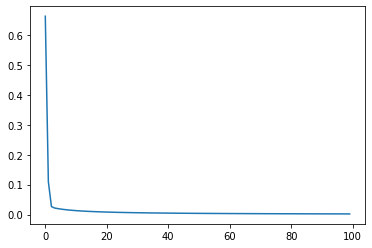

In [14]:
plt.plot(cost_list)

## Quantum classification

In [81]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

SOFTMAX_SCALE = 45

def softmax(x):
    x = np.array(x)
    x -= x.max(axis=1, keepdims=True) # avoid exp overflow
    x_exp = np.exp(x)
    return x_exp / np.sum(x_exp, axis=1, keepdims=True)

def one_hot(outputs):
    nlabels = len(set(outputs))
    return np.eye(nlabels)[outputs] # one-hot encoding.

def np_log(x):
    return np.log(np.clip(a=x, a_min=1e-10, a_max=1e+10))

def func(weights, nqubits, nlabels, input = None):
    qml.AngleEmbedding(input, wires=range(nqubits))
    qml.Barrier(only_visual=True, wires=range(nqubits))
    qml.StronglyEntanglingLayers(weights, wires=range(nqubits),)

    return [qml.expval(qml.PauliZ(wires=i)) for i in range(nlabels)] # size 2 for OR dataset

def cost_cross_entropy(params, nqubits, outputs, inputs):
    device = qml.device("default.qubit", wires=nqubits)
    qcircuit = qml.QNode(func, device)

    nlabels = len(set(outputs)) # 2

    predictions = softmax([SOFTMAX_SCALE * qcircuit(params, nqubits, nlabels, input=x) for x in inputs]) # 4*2
    one_hot_labels = one_hot(outputs) # 4*2

    results = []
    for (pd,l) in zip(predictions, one_hot_labels):
        results.append(-np.sum([l[j]*np_log(pd[j]) for j in range(nlabels)]))

    return np.mean(np.array(results))

def opt(inputs, scaling_factor, outputs, nqubits, nlayers, stepsize, max_steps=200):
    inputs = inputs * scaling_factor

    shape = qml.StronglyEntanglingLayers.shape(n_layers=nlayers, n_wires=nqubits)
    optweights = np.random.random(size=shape)

    cost_list = []
    opt = qml.AdamOptimizer(stepsize)
    for step in range(max_steps):
        optweights, cost_value = opt.step_and_cost(lambda w: cost_cross_entropy(w,nqubits,outputs,inputs), optweights)
        cost_list.append(cost_value)
        #print("{}\n{}".format(step,optweights))
    print("Cost at step {} ---> {}".format(step, cost_value))

    return optweights, cost_list

def draw_circuit(optweights, nqubits, inputs, outputs):
    nlabels = len(set(outputs))
    device = qml.device("default.qubit", wires=nqubits)
    qcircuit = qml.QNode(func, device)
    fig = qml.draw_mpl(qcircuit, expansion_strategy="device")(optweights, nqubits, nlabels, inputs[0])
    plt.show()

def plot_cost(cost_list):
    plt.plot(cost_list)
    plt.show()

def compare_outputs(optweights, nqubits, scaling_factor, inputs, outputs):
    nlabels = len(set(outputs))
    device = qml.device("default.qubit", wires=nqubits)
    qcircuit = qml.QNode(func, device)
    y_pred = softmax([SOFTMAX_SCALE * qcircuit(optweights, nqubits, nlabels, input=x) for x in inputs * scaling_factor])
    for i in range(4):
        print(one_hot(outputs)[i], y_pred[i].round(6))

### Test

In [98]:
inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
outputs = np.array([0, 1, 1, 1])
scaling_factor = np.pi/2

nqubits = 2; nlayers = 2; stepsize = 0.3;  max_steps = 300

In [99]:
optweights, cost_list = opt(inputs, scaling_factor, outputs, nqubits, nlayers, stepsize, max_steps)

Cost at step 299 ---> 5.72617345079227e-07


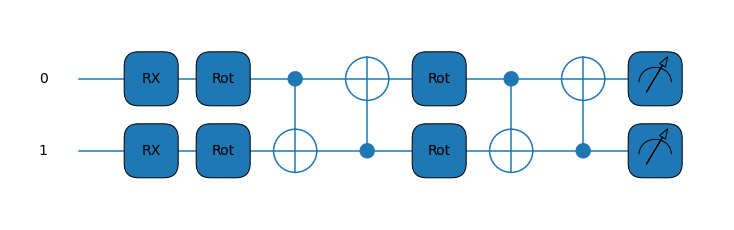

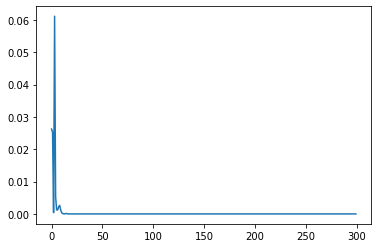

In [100]:
draw_circuit(optweights, nqubits, inputs, outputs)

plot_cost(cost_list)

In [101]:
compare_outputs(optweights, nqubits, scaling_factor, inputs, outputs)

[1. 0.] [9.99999e-01 1.00000e-06]
[0. 1.] [1.00000e-06 9.99999e-01]
[0. 1.] [0. 1.]
[0. 1.] [0. 1.]


### Inputs scaling factor vs optimized cost value

Instead of using the inputs data directly, we multiply the inputs data by a scaling factor.

In [57]:
inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
outputs = np.array([0, 1, 1, 1])
scaling_factor_list = np.linspace(0.1, 2, 20) * np.pi

nqubits = 2; nlayers = 2; stepsize = 0.3; max_steps = 300

In [58]:
cost_scaling_factor_list = []
for scaling_factor in scaling_factor_list:
    optweights, cost_list = opt(inputs, scaling_factor, outputs, nqubits, nlayers, stepsize, max_steps)
    cost_scaling_factor_list.append(cost_list[-1])

Cost at step 299 ---> 0.0005242638251825441
Cost at step 299 ---> 2.179320119542987e-06
Cost at step 299 ---> 1.9971325318921784e-06
Cost at step 299 ---> 3.0359623030576325e-07
Cost at step 299 ---> 5.72617345079227e-07
Cost at step 299 ---> 1.2269201226583617e-09
Cost at step 299 ---> 9.261438523740881e-09
Cost at step 299 ---> 4.6312043585578844e-05
Cost at step 299 ---> 3.9555102567016034e-05
Cost at step 299 ---> 5.294173479715157e-06
Cost at step 299 ---> 2.7946609321219904e-06
Cost at step 299 ---> 5.787781606402298e-08
Cost at step 299 ---> 1.5602861573704598e-06
Cost at step 299 ---> 1.045685893080484e-06
Cost at step 299 ---> 1.6710498889518756e-06
Cost at step 299 ---> 3.3305198677509526e-06
Cost at step 299 ---> 3.1694896075246204e-06
Cost at step 299 ---> 2.7270746708156934e-05
Cost at step 299 ---> 0.0005046880420169657
Cost at step 299 ---> 0.5623351446188141


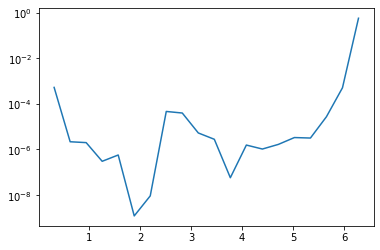

In [59]:
plt.semilogy(scaling_factor_list, cost_scaling_factor_list)
plt.show()

seems periodic

### Number of qubits vs optimized cost value

In [66]:
scaling_factor = np.pi/2
inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
outputs = np.array([0, 1, 1, 1])

nqubits_list = [2, 3, 4, 5, 6, 7, 8, 9]; stepsize = 0.3; max_steps = 300

In [61]:
nlayers = 2
cost_nqubits_list = []
for nqubits in nqubits_list:
    optweights, cost_list = opt(inputs, scaling_factor, outputs, nqubits, nlayers, stepsize, max_steps)
    cost_nqubits_list.append(cost_list[-1])

Cost at step 299 ---> 5.72617345079227e-07
Cost at step 299 ---> 3.158092806240861e-06
Cost at step 299 ---> 7.581887761139157e-07
Cost at step 299 ---> 4.1334825960486335e-06
Cost at step 299 ---> 6.185528451022916e-05
Cost at step 299 ---> 2.277038433047394e-06
Cost at step 299 ---> 3.5838564817359993e-06
Cost at step 299 ---> 3.1260774999529483e-06


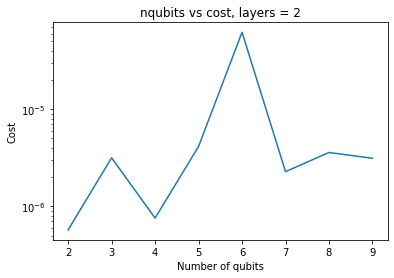

In [62]:
plt.semilogy(nqubits_list, cost_nqubits_list)
plt.xlabel("Number of qubits")
plt.ylabel("Cost")
plt.title("nqubits vs cost, layers = 2")
plt.show()

In [67]:
nlayers = 3
cost_nqubits_list = []
for nqubits in nqubits_list:
    optweights, cost_list = opt(inputs, scaling_factor, outputs, nqubits, nlayers, stepsize, max_steps)
    cost_nqubits_list.append(cost_list[-1])

Cost at step 299 ---> 5.407811981530873e-10
Cost at step 299 ---> 6.458523702219017e-07
Cost at step 299 ---> 3.858369330338247e-06
Cost at step 299 ---> 5.4040637425688805e-06
Cost at step 299 ---> 2.2378152793074383e-06
Cost at step 299 ---> 1.1264697233473757e-05
Cost at step 299 ---> 8.551879296937744e-07
Cost at step 299 ---> 3.6422981434696717e-06


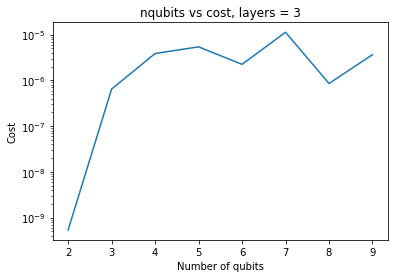

In [68]:
plt.semilogy(nqubits_list, cost_nqubits_list)
plt.xlabel("Number of qubits")
plt.ylabel("Cost")
plt.title("nqubits vs cost, layers = 3")
plt.show()

### Number of layers vs optimized cost value

In [63]:
scaling_factor = np.pi/2
inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
outputs = np.array([0, 1, 1, 1])

nqubits = 2; nlayers_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]
stepsize = 0.3; max_steps = 300

In [64]:
cost_nlayers_list = []
for nlayers in nlayers_list:
    optweights, cost_list = opt(inputs, scaling_factor, outputs, nqubits, nlayers, stepsize, max_steps)
    cost_nlayers_list.append(cost_list[-1])

Cost at step 299 ---> 0.21388171830333447
Cost at step 299 ---> 5.72617345079227e-07
Cost at step 299 ---> 5.407811981530873e-10
Cost at step 299 ---> 2.091405773872578e-06
Cost at step 299 ---> 4.802318654334764e-06
Cost at step 299 ---> 6.357165085976118e-07
Cost at step 299 ---> 2.4267663992773823e-07
Cost at step 299 ---> 2.207604303559419e-09
Cost at step 299 ---> 4.385496260847064e-07


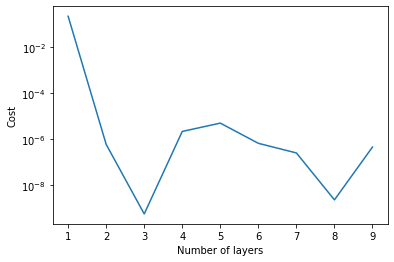

In [65]:
plt.semilogy(nlayers_list, cost_nlayers_list)
plt.xlabel("Number of layers")
plt.ylabel("Cost")
plt.show()